In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../../data.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(31, 32), dtype=bool)

In [6]:
print(motion.shape)

(7397, 33)


# Dataset Preparation

In [7]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [9]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [11]:
def get_accelerations_footstep_dataset(dataset, footsteps, debug=False):
    idx = 1
    inputs = []
    labels = []
    
    while idx < len(footsteps):
        if idx > 0:
            # Compute time difference between footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            # Round velocity array
            dataset[footsteps[idx-1], 1:4] = np.round(dataset[footsteps[idx-1], 1:4], 1)
            dataset[footsteps[idx], 1:4] = np.round(dataset[footsteps[idx], 1:4], 1)
            
            if time_difference < 0.4:
                fl_rr_moving = contacts[footsteps[idx], 0]
                fr_rl_moving = contacts[footsteps[idx], 1]
                
                if fl_rr_moving == fr_rl_moving:
                    print("Invalid footstep")
                    idx += 1
                    continue
                    
                # Rotation matrices
                R_curr = np.array([[dataset[footsteps[idx], 22], dataset[footsteps[idx], 23], dataset[footsteps[idx], 24]], 
                                   [dataset[footsteps[idx], 25], dataset[footsteps[idx], 26], dataset[footsteps[idx], 27]], 
                                   [dataset[footsteps[idx], 28], dataset[footsteps[idx], 29], dataset[footsteps[idx], 30]]])
                R_prev = np.array([[dataset[footsteps[idx-1], 22], dataset[footsteps[idx-1], 23], dataset[footsteps[idx-1], 24]], 
                                   [dataset[footsteps[idx-1], 25], dataset[footsteps[idx-1], 26], dataset[footsteps[idx-1], 27]], 
                                   [dataset[footsteps[idx-1], 28], dataset[footsteps[idx-1], 29], dataset[footsteps[idx-1], 30]]])

                # Retrieve base poses in world frame
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Compute base displacement
                world_displacement = curr_base - prev_base
                base_displacement = np.dot(R_curr.T, world_displacement)
                
                # Compute prev feet poses w.r.t the base
                prev_fl_pose_base = np.dot(R_prev.T, dataset[footsteps[idx-1], 4:7] - prev_base)
                prev_fr_pose_base = np.dot(R_prev.T, dataset[footsteps[idx-1], 7:10] - prev_base)
                prev_rl_pose_base = np.dot(R_prev.T, dataset[footsteps[idx-1], 10:13] - prev_base)
                prev_rr_pose_base = np.dot(R_prev.T, dataset[footsteps[idx-1], 13:16] - prev_base)
                prev_feet_poses_base = prev_fl_pose_base.tolist() + \
                                       prev_fr_pose_base.tolist() + \
                                       prev_rl_pose_base.tolist() + \
                                       prev_rr_pose_base.tolist()
                
                # Compute curr feet poses w.r.t the base
                curr_fl_pose_base = np.dot(R_curr.T, dataset[footsteps[idx], 4:7] - curr_base)
                curr_fr_pose_base = np.dot(R_curr.T, dataset[footsteps[idx], 7:10] - curr_base)
                curr_rl_pose_base = np.dot(R_curr.T, dataset[footsteps[idx], 10:13] - curr_base)
                curr_rr_pose_base = np.dot(R_curr.T, dataset[footsteps[idx], 13:16] - curr_base)

                inputs.append(dataset[footsteps[idx-1], 1:4].tolist() + # previous cmd
                              dataset[footsteps[idx], 1:4].tolist() + # current cmd
                              np.dot(R_prev.T, dataset[footsteps[idx-1], 19:22]).tolist() + # current velocity
                              prev_feet_poses_base + # feet position w.r.t CoM
                              [fl_rr_moving, fr_rl_moving]) # swiging booleans
                
                if fl_rr_moving:                    
                    fl_displacement = (curr_fl_pose_base - prev_fl_pose_base) + base_displacement
                    rr_displacement = (curr_rr_pose_base - prev_rr_pose_base) + base_displacement
                    labels.append([fl_displacement[0], fl_displacement[1], rr_displacement[0], rr_displacement[1]])
                else:
                    fr_displacement = (curr_fr_pose_base - prev_fr_pose_base) + base_displacement
                    rl_displacement = (curr_rl_pose_base - prev_rl_pose_base) + base_displacement
                    labels.append([fr_displacement[0], fr_displacement[1], rl_displacement[0], rl_displacement[1]])
            
        idx += 1
        
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

# Stack datasets
X_footsteps_accelerations_absolute, Y_footsteps_accelerations_absolute = get_accelerations_footstep_dataset(motion, np.array([x for x in range(len(motion))]))

# Log
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(7395, 23)
(7395, 4)


In [12]:
%store X_footsteps_accelerations_absolute
%store Y_footsteps_accelerations_absolute

Stored 'X_footsteps_accelerations_absolute' (ndarray)
Stored 'Y_footsteps_accelerations_absolute' (ndarray)


In [59]:
dic = dict()
for x in range(len(X_footsteps_accelerations_absolute)):
    key = str(round(X_footsteps_accelerations_absolute[x, 0], 1)) + str(round(X_footsteps_accelerations_absolute[x, 3], 1))
    if key in dic:
        dic[key][0].append(Y_footsteps_accelerations_absolute[x, 0])
        dic[key][1].append(X_footsteps_accelerations_absolute[x, 6])
        dic[key][2].append((X_footsteps_accelerations_absolute[x, 10],
                            X_footsteps_accelerations_absolute[x, 13]))
    else:
        dic[key] = [[Y_footsteps_accelerations_absolute[x, 0]], 
                    [X_footsteps_accelerations_absolute[x, 6]],
                    [(X_footsteps_accelerations_absolute[x, 10],
                      X_footsteps_accelerations_absolute[x, 13])]]


In [60]:
#for key in dic.keys():
#    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
#    if float(key[:3]) == 1.0 and float(key[3:]) == 1.0:
#        for x in range(len(dic[key][0])):
#            print(f"Actual velocity: {dic[key][1][x]}. Displacement: {dic[key][0][x]}")

In [61]:
#for key in dic.keys():
#    print(f"Prev: {key[:3]}. Actual: {key[3:]}. \n\nDisp: {dic[key]}\n\n.")

In [62]:
#for x in range(len(X_footsteps_accelerations_absolute)):
#    print(f"{X_footsteps_accelerations_absolute[x, 0]} -> {X_footsteps_accelerations_absolute[x, 3]}. Step: {np.round(Y_footsteps_accelerations_absolute[x, 0], 2)}. CoM: {np.round(X_footsteps_accelerations_absolute[x, -5:-4], 2)}. FL: {np.round(X_footsteps_accelerations_absolute[x, 10], 3)}. FR: {np.round(X_footsteps_accelerations_absolute[x, 13], 3)}. RL: {np.round(X_footsteps_accelerations_absolute[x, 16], 3)}. RR: {np.round(X_footsteps_accelerations_absolute[x, 19], 3)}")

0.0 -> 0.0. Mean: -0.032. Std: 0.037
0.1 -> 0.1. Mean: 0.013. Std: 0.035
0.2 -> 0.2. Mean: 0.052. Std: 0.039
0.3 -> 0.3. Mean: 0.091. Std: 0.045
0.4 -> 0.4. Mean: 0.13. Std: 0.056
0.5 -> 0.5. Mean: 0.168. Std: 0.069
0.6 -> 0.6. Mean: 0.207. Std: 0.079
0.7 -> 0.7. Mean: 0.25. Std: 0.094
0.8 -> 0.8. Mean: 0.295. Std: 0.103
0.9 -> 0.9. Mean: 0.338. Std: 0.119
1.0 -> 1.0. Mean: 0.378. Std: 0.134
1.1 -> 1.1. Mean: 0.414. Std: 0.146


<ErrorbarContainer object of 3 artists>

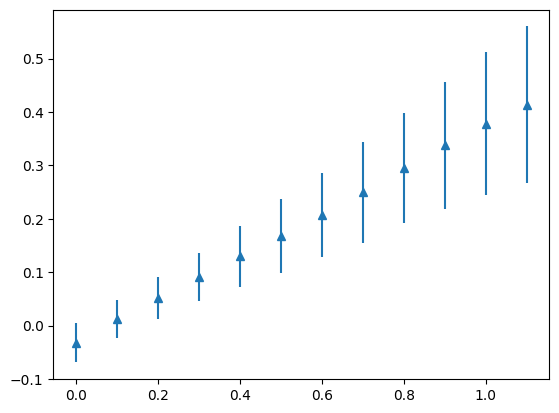

In [63]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.2, 0.1), 2):
    start = vel
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')